In [229]:
!pip install xgboost

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [231]:
df=pd.read_csv("housing.csv")

In [232]:
df=df.dropna()
print(df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [233]:
df['population_per_household']=df['population']/df['households']
df["rooms_per_house"]=df["total_rooms"]/df["households"]
df.drop("total_rooms",axis=1,inplace=True)

In [234]:
features=['median_income','housing_median_age','population_per_household','ocean_proximity','rooms_per_house']
X=df[features]
y=df['median_house_value']
numeric_features=['median_income','housing_median_age','population_per_household','rooms_per_house']
categorical_features=['ocean_proximity']

preprocessor=ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)


In [235]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
print("Average R²:", scores.mean())

Average R²: 0.7193632222116266


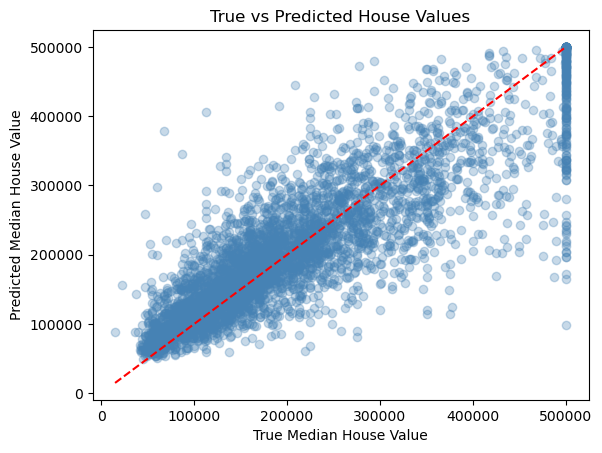

In [236]:
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("True vs Predicted House Values")
min_val = min(y_test.min(),y_pred.min())
max_val = max(y_test.max(),y_pred.max())
plt.plot([min_val,max_val],[min_val,max_val], 'r--')
plt.show()

In [237]:
import joblib

joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(pipeline,"model.joblib")

['model.joblib']